<a href="https://colab.research.google.com/github/ewclark47/ADL-Project/blob/main/transformer_nmt_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 22 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 17s (25.9 MB/s)
(Reading database ... 122352 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 122319 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.

In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

import re, collections

In [3]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

2638744/2638744 [==============================] - 0s 0us/step


In [83]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [84]:
target_raw, context_raw = load_data(path_to_file)

In [85]:
is_train = np.random.uniform(size=(len(target_raw),)) < 0.7

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    )
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    )

In [86]:
for es, en in train_raw.take(1):
  print('Spanish: ', es.numpy().decode())
  print('English: ', en.numpy().decode())

Spanish:  Ve.
English:  Go.


In [87]:
train_es = train_raw.map(lambda es, en: es)
train_en = train_raw.map(lambda es, en: en)

In [88]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [184]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=['[PAD]', '[UNK]', '[START]', '[END]']

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [185]:
%%time
es_vocab = bert_vocab.bert_vocab_from_dataset(
    train_es.batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 1min 18s, sys: 861 ms, total: 1min 19s
Wall time: 1min 21s


In [186]:
with open('es_vocab.txt', 'w') as f:
  for token in es_vocab:
    print(token, file=f)

In [187]:
%%time
en_vocab = bert_vocab.bert_vocab_from_dataset(
    train_en.batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 38.8 s, sys: 700 ms, total: 39.5 s
Wall time: 39.7 s


In [188]:
with open('en_vocab.txt', 'w') as f:
  for token in en_vocab:
    print(token, file=f)

In [189]:
es_tokenizer = tensorflow_text.BertTokenizer('es_vocab.txt', **bert_tokenizer_params)
en_tokenizer = tensorflow_text.BertTokenizer('en_vocab.txt', **bert_tokenizer_params)

In [190]:
for es_ex, en_ex in train_raw.batch(5).take(1):
  for ex in en_ex:
    print(ex.numpy())

b'Go.'
b'Go.'
b'Go.'
b'Hi.'
b'Run!'


In [191]:
token_batch = en_tokenizer.tokenize(en_ex)
token_batch = token_batch.merge_dims(-2,-1)
for ex in token_batch.to_list():
  print(ex)

[70, 5]
[70, 5]
[70, 5]
[2825, 5]
[510, 3]


In [192]:
txt_tokens = tf.gather(en_vocab, token_batch)
tf.strings.reduce_join(txt_tokens, separator=' ', axis=-1)

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'me "', b'me "', b'me "', b'doors "', b'summer [END]'],
      dtype=object)>

In [193]:
words = en_tokenizer.detokenize(token_batch)
tf.strings.reduce_join(words, separator=' ', axis=-1)

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'go .', b'go .', b'go .', b'hi .', b'run !'], dtype=object)>

In [200]:
START = tf.argmax(tf.constant(reserved_tokens) == '[START]') # I have no idea why but using [START] gives me the token for [END] and using [UNK] gives me [START]
ENDING = tf.argmax(tf.constant(reserved_tokens) == '[END]')
UNK = tf.argmax(tf.constant(reserved_tokens) == '[UNK]')

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count, 1], START)
  ends = tf.fill([count,1], ENDING)
  unk = tf.fill([count, 1], UNK)
  return tf.concat([unk, ragged, starts], axis=1)

In [201]:
words = en_tokenizer.detokenize(add_start_end(token_batch))
tf.strings.reduce_join(words, separator=' ', axis=-1)

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'[START] go . [END]', b'[START] go . [END]',
       b'[START] go . [END]', b'[START] hi . [END]',
       b'[START] run ! [END]'], dtype=object)>

In [202]:
def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [203]:
token_batch = en_tokenizer.tokenize(en_ex).merge_dims(-2,-1)
words = en_tokenizer.detokenize(token_batch)
words

<tf.RaggedTensor [[b'go', b'.'],
 [b'go', b'.'],
 [b'go', b'.'],
 [b'hi', b'.'],
 [b'run', b'!']]>

In [204]:
cleanup_text(reserved_tokens, words).numpy()

array([b'go .', b'go .', b'go .', b'hi .', b'run !'], dtype=object)

In [208]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = tensorflow_text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [209]:
tokenizers = tf.Module()
tokenizers.es = CustomTokenizer(reserved_tokens, 'es_vocab.txt')
tokenizers.en = CustomTokenizer(reserved_tokens, 'en_vocab.txt')

In [210]:
model_name = 'ADL_tokenizer_es_en_translator'
tf.saved_model.save(tokenizers, model_name)

In [65]:
def make_lower_add_space(text):
  # Split accented characters.
  text = tensorflow_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿\']', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

In [ ]:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 13, 124, 386, 8, 136, 12, 3], [2, 9, 78, 414, 177, 4, 3],
 [2, 47, 1199, 19, 95, 889, 680, 4, 3]]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary()) # example usage of get_vocabulary() method that will be necessary later
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] ¿ quieres volver a boston ? [END]'

In [ ]:
def process_text(context, target): 
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:, :-1].to_tensor()
  targ_out = target[:, 1:].to_tensor()
  return (context, targ_in), targ_out

In [ ]:
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)
test_ds = test_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (es, en), en_labels in train_ds.take(1):
  print(es[0, :10].numpy()) 
  print()
  print(en[0, :10].numpy()) 
  print(en_labels[0, :10].numpy())

[  2 425   1  35   4   3   0   0   0   0]

[   2    8   88    7 1248   90    4    0    0    0]
[   8   88    7 1248   90    4    3    0    0    0]


In [ ]:
for (es, en), en_labels in train_ds.take(1):
  break
print(es.shape)
print(en.shape)
print(en_labels.shape)

(64, 17)
(64, 18)
(64, 18)


## The Transformer

### Embedding and Positional Encoding

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]
  depths = np.arange(depth)[np.newaxis, :]/depth 

  angle_rates = 1/(10000**depths) 
  angle_rads = positions * angle_rates 

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)], axis=-1
  )

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer): 
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x+self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
embed_es = PositionalEmbedding(vocab_size = len(context_text_processor.get_vocabulary()), d_model = 512)
embed_en = PositionalEmbedding(vocab_size = len(target_text_processor.get_vocabulary()), d_model = 512)

es_emb = embed_es(es)
en_emb = embed_en(en)

In [ ]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 18), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Attention and Layer Normalization

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query = x,
        key = context, 
        value = context, 
        return_attention_scores=True
    )

    self.last_attn_scores = attn_scores # cache the attention scores for plotting later

    x = self.add([x, attn_output]) 
    x = self.layernorm(x)  

    return x

In [ ]:
sample_ca = CrossAttention(num_heads = 2, key_dim=512) 

print(es_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, es_emb).shape)

(64, 17, 512)
(64, 18, 512)
(64, 18, 512)


In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query = x, 
        value = x, 
        key = x
    )

    x = self.add([x, attn_output])
    x = self.layernorm(x) 

    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(es_emb.shape)
print(sample_gsa(es_emb).shape)

(64, 17, 512)
(64, 17, 512)


In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query = x, 
        value = x,
        key = x,
        use_causal_mask = True
    )

    x = self.add([x, attn_output])
    x = self.layernorm(x) 

    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 18, 512)
(64, 18, 512)


### Feed Forward

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate = 0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation = 'relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layernorm(x) 

    return x

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 18, 512)
(64, 18, 512)


### The Encoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads = num_heads,
        key_dim = d_model, 
        dropout = dropout_rate
    )

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x) 
    x = self.ffn(x) 
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(es_emb.shape)
print(sample_encoder_layer(es_emb).shape)

(64, 17, 512)
(64, 17, 512)


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate = 0.1):
    super().__init__()

    self.d_model = d_model 
    self.num_layers = num_layers 

    self.pos_embedding = PositionalEmbedding(
        vocab_size = vocab_size,
        d_model = d_model 
    )
    self.enc_layers = [
        EncoderLayer(
            d_model = d_model, 
            num_heads = num_heads,
            dff = dff,
            dropout_rate = dropout_rate 
        )
        for _ in range(num_layers)
    ]

    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x): 
    x = self.pos_embedding(x) 
    x = self.dropout(x) 

    for i in range(self.num_layers): 
      x = self.enc_layers[i](x) 

    return x

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(es, training=False)

# Print the shape.
print(es.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 17)
(64, 17, 512)


### The Decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer): 
  def __init__(self, *, d_model, num_heads, dff, dropout_rate = 0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads = num_heads, 
        key_dim = d_model, 
        dropout = dropout_rate 
    )

    self.cross_attention = CrossAttention(
        num_heads = num_heads, 
        key_dim = d_model, 
        dropout = dropout_rate 
    )

    self.ffn = FeedForward(d_model, dff) 

  def call(self, x, context):
    x = self.causal_self_attention(x = x) 
    x = self.cross_attention(x = x, context = context) 

    self.last_attn_scores = self.cross_attention.last_attn_scores # cache for plotting later

    x = self.ffn(x) 

    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=es_emb)

print(en_emb.shape)
print(es_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 18, 512)
(64, 17, 512)
(64, 18, 512)


In [ ]:
class Decoder(tf.keras.layers.Layer): 
  @classmethod
  def add_method(cls, fun): 
    setattr(cls, fun.__name__, fun) 
    return fun 
    
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate = 0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model 
    self.num_layers = num_layers 

    self.pos_embedding = PositionalEmbedding(
        vocab_size = vocab_size, 
        d_model = d_model 
    )

    self.dropout = tf.keras.layers.Dropout(dropout_rate) 

    self.dec_layers = [
        DecoderLayer(
            d_model = d_model, 
            num_heads = num_heads, 
            dff = dff, 
            dropout_rate = dropout_rate
        )
        for _ in range(num_layers)
    ]

    self.last_attn_scores = None 

  def call(self, x, context): 
    x = self.pos_embedding(x) 
    x = self.dropout(x) 

    for i in range(self.num_layers): 
      x = self.dec_layers[i](x, context) 

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores 

    return x

In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens): 
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=es_emb)

# Print the shapes.
print(en.shape)
print(es_emb.shape)
print(output.shape)

(64, 18)
(64, 17, 512)
(64, 18, 512)


In [ ]:
sample_decoder.last_attn_scores.shape

TensorShape([64, 8, 18, 17])

### Transformer

In [ ]:
class Transformer(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun 
    
  def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate = 0.1):
    super().__init__()

    self.encoder = Encoder(
        num_layers = num_layers,
        d_model = d_model, 
        num_heads = num_heads, 
        dff = dff, 
        vocab_size = input_vocab_size, 
        dropout_rate = dropout_rate 
    )
    
    self.decoder = Decoder(
        num_layers = num_layers, 
        d_model = d_model, 
        num_heads = num_heads, 
        dff = dff, 
        vocab_size = target_vocab_size, 
        dropout_rate = dropout_rate 
    )

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    context, x = inputs # to use '.fit' all inputs need passed in the first argument

    context = self.encoder(context) 

    x = self.decoder(x, context) 

    logits = self.final_layer(x) 

    try:
      del logits._keras_mask 
    except AttributeError:
      pass 

    return logits

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
transformer = Transformer(
    num_layers = num_layers, 
    d_model = d_model, 
    num_heads = num_heads, 
    dff = dff, 
    input_vocab_size = len(context_text_processor.get_vocabulary()), 
    target_vocab_size = len(target_text_processor.get_vocabulary()), 
    dropout_rate = dropout_rate
)

In [ ]:
output = transformer((es, en))

print(en.shape)
print(es.shape)
print(output.shape)

(64, 18)
(64, 17)
(64, 18, 5000)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores 
print(attn_scores.shape)

(64, 8, 18, 17)


In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3278848   
                                                                 
 decoder_1 (Decoder)         multiple                  5389824   
                                                                 
 dense_38 (Dense)            multiple                  645000    
                                                                 
Total params: 9,313,672
Trainable params: 9,313,672
Non-trainable params: 0
_________________________________________________________________


### Training

Custom learning rate scheduler (as used in the original paper) to be used with Adam optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule): 
  def __init__(self, d_model, warmup_steps = 4000): 
    super().__init__() 

    self.d_model = d_model 
    self.d_model = tf.cast(self.d_model, tf.float32) 

    self.warmup_steps = warmup_steps 

  def __call__(self, step): 
    step = tf.cast(step, dtype = tf.float32) 
    arg1 = tf.math.rsqrt(step) 
    arg2 = step*(self.warmup_steps ** -1.5) 

    return tf.math.rsqrt(self.d_model)*tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model) 

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = .9, beta_2 = .98, epsilon = 1e-9)

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits = True, reduction = 'none'
  ) 
  loss = loss_object(label, pred) 

  mask = tf.cast(mask, dtype = loss.dtype) 
  loss *= mask 

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask) 

  return loss 

def masked_accuracy(label, pred): 
  pred = tf.argmax(pred, axis=2) 
  label = tf.cast(label, pred.dtype) 
  match = label == pred 

  mask = label != 0 

  match = match & mask 

  match = tf.cast(match, dtype = tf.float32) 
  mask = tf.cast(mask, dtype = tf.float32) 

  return tf.reduce_sum(match)/tf.reduce_sum(mask) 

In [ ]:
transformer.compile(
    loss = masked_loss, 
    optimizer = optimizer, 
    metrics = [masked_accuracy]
)

In [ ]:
history = transformer.fit(train_ds.repeat(), epochs=100, steps_per_epoch = 100, validation_data = val_ds, validation_steps = 20, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 281s 3s/step - loss: 8.2267 - masked_accuracy: 0.0874 - val_loss: 7.8972 - val_masked_accuracy: 0.1199
Epoch 2/100
100/100 [==============================] - 242s 2s/step - loss: 7.5554 - masked_accuracy: 0.1841 - val_loss: 7.0781 - val_masked_accuracy: 0.2197
Epoch 3/100
100/100 [==============================] - 235s 2s/step - loss: 6.6025 - masked_accuracy: 0.2248 - val_loss: 6.0683 - val_masked_accuracy: 0.2229
Epoch 4/100
100/100 [==============================] - 237s 2s/step - loss: 5.6555 - masked_accuracy: 0.2452 - val_loss: 5.2306 - val_masked_accuracy: 0.2788
Epoch 5/100
100/100 [==============================] - 240s 2s/step - loss: 4.9933 - masked_accuracy: 0.3055 - val_loss: 4.7241 - val_masked_accuracy: 0.3210
Epoch 6/100
100/100 [==============================] - 238s 2s/step - loss: 4.5279 - masked_accuracy: 0.3463 - val_loss: 4.2521 - val_masked_accuracy: 0.3737
Epoch 7/100
100/100 [==============================]

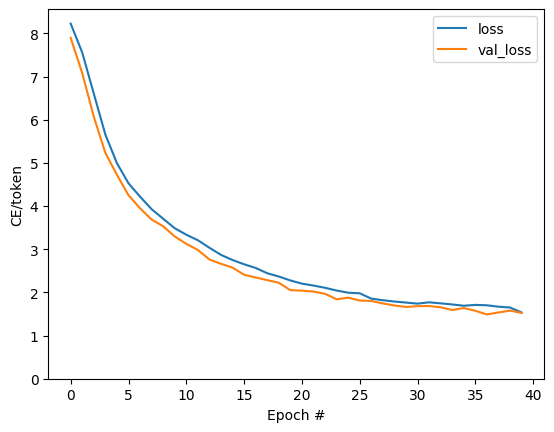

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

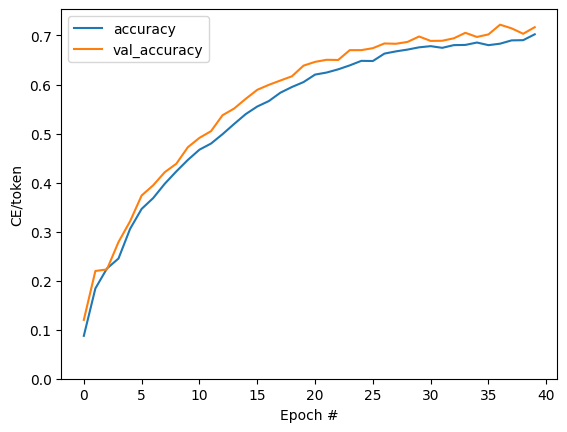

In [ ]:
plt.plot(history.history['masked_accuracy'], label='accuracy')
plt.plot(history.history['val_masked_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
class Translator(tf.Module): 
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, context_tokenizer, target_tokenizer, transformer):
    self.context_tokenizer = context_tokenizer
    self.target_tokenizer = target_tokenizer
    self.transformer = transformer

  def __call__(self, sentence, max_length=50):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.context_tokenizer(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.target_tokenizer([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    #print('before transpose: ', output)
    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    vocab = np.array(self.target_tokenizer.get_vocabulary())

    indeces = []
    for i in range(len(output[0].numpy())):
      indeces.append(output[0].numpy()[i])

    text = ''
    for idx in indeces[1:-1]:
      text += vocab[idx] + ' '
    #print(text)

    tokens = vocab[output[0].numpy()]

    

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights
  

In [ ]:
translator = Translator(context_text_processor, target_text_processor, transformer)

In [ ]:
@Translator.add_method
def print_translation(self, sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
@Translator.add_method
def plot_attention_head(self, in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label for label in in_tokens]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label for label in translated_tokens]
  ax.set_yticklabels(labels)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [ ]:
@Translator.add_method
def bleu_score(self, sentence, reference):
  translated_sent, translated_tokens, attn_weights = self(tf.constant(sentence))
  #print('translation is: ', translated_sent)
  output = [word for word in translated_sent.split()]

  reference = [tf_lower_and_split_punct(reference).numpy().decode().split()[1:-1]]
  #print('ref is: ', reference)

  sent_bleu = sentence_bleu(reference, output)

  print(f'Reference Text: {reference}')
  print(f'Candidate Text: {output}')
  print(f'BLEU Score: {sent_bleu}')

In [ ]:
sentence = 'Esta es mi vida.'
ground_truth = 'this is my life.'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
translator.print_translation(sentence, translated_text, ground_truth)

Input:         : Esta es mi vida.
Prediction     : this is my life . 
Ground truth   : this is my life.


In [ ]:
translator.bleu_score(sentence, ground_truth)

translation is:  this is my life . 
Reference Text: [['this', 'is', 'my', 'life', '.']]
Candidate Text: ['this', 'is', 'my', 'life', '.']
BLEU Score: 1.0


In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([7, 7])

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = context_text_processor(in_tokens).to_tensor()
context_vocab = np.array(context_text_processor.get_vocabulary())
in_tokens = context_vocab[in_tokens[0].numpy()]
' '.join(in_tokens)
in_tokens

array(['[START]', 'esta', 'es', 'mi', 'vida', '.', '[END]'], dtype='<U18')

In [ ]:
translated_tokens

array(['[START]', 'this', 'is', 'my', 'life', '.', '[END]'], dtype='<U16')

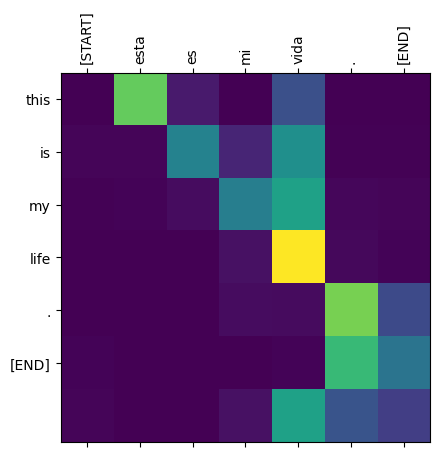

In [ ]:
translator.plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
sentence = 'No creo que funciona para frases largas.'
ground_truth = 'I dont think this works for long sentences'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
translator.print_translation(sentence, translated_text, ground_truth)

Input:         : No creo que funciona para frases largas.
Prediction     : i dont think it works for [UNK] . 
Ground truth   : I dont think this works for long sentences


In [ ]:
translator.bleu_score(sentence, ground_truth)

translation is:  i dont think it works for [UNK] . 
Reference Text: [['i', 'dont', 'think', 'this', 'works', 'for', 'long', 'sentences']]
Candidate Text: ['i', 'dont', 'think', 'it', 'works', 'for', '[UNK]', '.']
BLEU Score: 5.614021910443866e-78


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([10, 10])

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = context_text_processor(in_tokens).to_tensor()
context_vocab = np.array(context_text_processor.get_vocabulary())
in_tokens = context_vocab[in_tokens[0].numpy()]
' '.join(in_tokens)
in_tokens

array(['[START]', 'no', 'creo', 'que', 'funciona', 'para', '[UNK]',
       'largas', '.', '[END]'], dtype='<U18')

In [ ]:
translated_tokens

array(['[START]', 'i', 'dont', 'think', 'it', 'works', 'for', '[UNK]',
       '.', '[END]'], dtype='<U16')

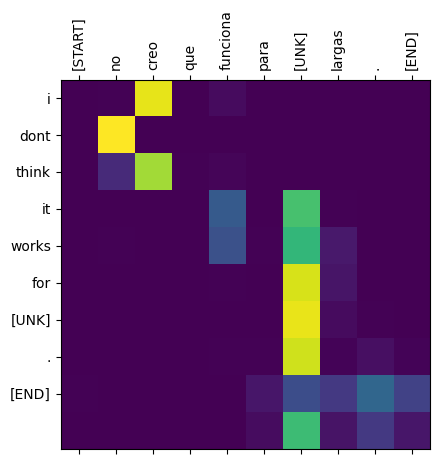

In [ ]:
translator.plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
sentence = "Ésta es mi entrenadora."
ground_truth = 'This is my coach.'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
translator.print_translation(sentence, translated_text, ground_truth)

Input:         : Ésta es mi entrenadora.
Prediction     : this is my [UNK] . 
Ground truth   : This is my coach.


In [ ]:
es_sentences = []
ref_sentences = []
for a, b in test_raw.take(5):
  for sent in a:
    es_sentences.append(sent.numpy().decode())
  for sent in b:
    ref_sentences.append([word for word in sent.numpy().decode().split()])
print(es_sentences)
print(es_sentences[1])
print(ref_sentences)

['Esta caja no es tan grande como la otra.', 'Me he acostumbrado a vivir solo.', 'Su llegada alteró completamente nuestra vida.', 'No está ahí.', '¿Qué es de tu esposa?', 'No vivimos en un mundo perfecto.', 'No te entiendo.', 'Él está logrando grandes avances en inglés.', 'Me gustaría leer algunos libros sobre Lincoln.', 'No quiero almorzar.', 'Eres como Tom.', 'Semejante idea es repugnante para ella.', 'Estoy tan gorda.', 'No se puede sobrevivir sin dinero.', 'Aquí tienes que hacerte la cama.', 'Fumar es malo para la salud.', '¿Cuántas personas hay en esta habitación?', 'Tom nunca supo lo que pasó.', '¿Puedo salir a caminar?', 'Yo no era tan fuerte como mi padre.', 'Me hizo sonreír.', '¿No puedes encontrarlo?', 'Eso sería extraño.', 'Mira allí.', 'Tom no quiso romperle el corazón a Mary.', 'Mucha gente lo hace.', 'Escuchemos lo que Tom tiene que decir.', 'Él es incapaz de comprar un coche.', 'Tomás sabe lo que usted hizo.', 'Yo no veo la televisión.', 'No me gustó el resultado.', 'Sol

In [ ]:
@Translator.add_method
def test_set_bleu(self, raw_test_data):
  es_sentences = []
  ref_sentences = []
  for es, en in raw_test_data.take(len(raw_test_data)):
    for sent in es:
      es_sentences.append(sent.numpy().decode())
    for sent in en:
      ref_sentences.append([word for word in sent.numpy().decode().split()])

  bleu_scores = []

  for i in range(len(es_sentences)):
    translated_sent, translated_tokens, attn_weights = self(tf.constant(es_sentences[i]))
    output = [word for word in translated_sent.split()]

    sent_bleu = sentence_bleu(ref_sentences[i], output, weights=(1,0,0,0))
    bleu_scores.append(sent_bleu)

  return bleu_scores

In [ ]:
bleu_list = translator.test_set_bleu(test_raw)
print(bleu_list[0:5])

/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [ ]:
translator = ExportTranslator(translator)

In [ ]:
path = 'gdrive/My Drive/translator'

tf.saved_model.save(translator, path)

TypeError: ignored

In [ ]:
reloaded = tf.saved_model.load(path)

In [ ]:
reloaded('esta es mi vida.').numpy()

TypeError: ignored